# Reference:

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

https://clay-atlas.com/blog/2020/05/12/pytorch-lstm-%E7%9A%84%E5%8E%9F%E7%90%86%E8%88%87%E8%BC%B8%E5%85%A5%E8%BC%B8%E5%87%BA%E6%A0%BC%E5%BC%8F%E7%B4%80%E9%8C%84/

https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

https://www.crosstab.io/articles/time-series-pytorch-lstm

https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/bidirectional_recurrent_neural_network/main.py

In [3]:
#匯入excel file，並且列出目前有的sheet 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch #https://www.pythonf.cn/read/40575 #https://pytorch.org/

# Step 1：載入資料

In [4]:
#匯入資料，並且取出第一張sheet -- WTI
file = 'Pytorch_ML專題_整理資料.xlsx'
data = pd.ExcelFile(file)
print(data.sheet_names)

df1 = data.parse('WTI', index_col="Dates")
df1

['WTI', 'Brent', '總經因子(月)']


,WTI,美國原油需求,美國原油供給,美國進出口,原油每周庫存,庫辛區庫存,美國汽油庫存總變動,鑽油井數,投機者期貨部位,美國指數,加幣,盧布,美國十年期公債,美國長短天期利差,S&P,股市波動度,CRB INDEX
Dates,,,,,,,,,,,,,,,,,
2021-12-03,66.26,19837,11700,3631,432870,30917,3882,467,367232,96.117,1.2843,73.8889,1.3430,74.974,4538.43,30.67,69.51
2021-11-26,68.15,20222,11600,3338,433111,28544,4029,467,387234,96.089,1.2791,75.6090,1.4731,96.750,4594.62,28.62,71.59
2021-11-19,76.10,21752,11500,3174,434020,27385,-603,461,407657,96.031,1.2640,73.4810,1.5462,103.544,4697.96,17.91,78.12
2021-11-12,80.79,21629,11400,3084,433003,26598,-707,454,415785,95.128,1.2550,72.9087,1.5613,104.381,4682.85,16.29,81.13
2021-11-05,81.27,19290,11500,3134,435104,26382,-1555,450,421312,94.320,1.2457,71.2684,1.4513,104.457,4697.53,16.48,81.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-06-03,55.03,20592,5515,10503,314711,19965,-31,146,1375,88.040,1.2467,28.3705,3.9732,41.050,1196.02,12.15,54.83
2005-05-27,51.85,20433,5537,10446,317706,20417,1304,148,-17401,86.420,1.2542,28.0800,4.0709,43.359,1198.78,12.15,51.14
2005-05-20,46.80,20584,5539,10339,316218,20540,609,146,-14319,86.630,1.2660,28.0292,4.1210,46.092,1189.28,13.14,48.88


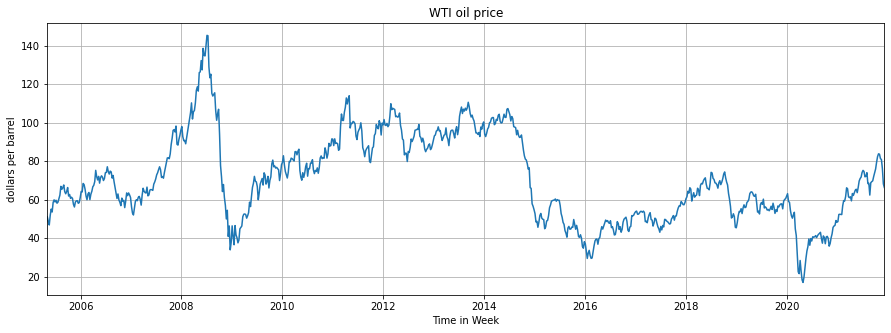

In [5]:
#plotting the WTI oil price 

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('WTI oil price')
plt.ylabel('dollars per barrel')
plt.xlabel('Time in Week')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df1['WTI'])

# Step 2: 資料處理(Data Preprocessing)

1. 離群值檢查
2. 相關係數檢查
3. Splitting data into training/testing 
4. 正規化training dataset 

**1. 離群值檢查**

In [5]:
list1 = df1.columns
list1

Index(['WTI', '美國原油需求', '美國原油供給', '美國進出口', '原油每周庫存', '庫辛區庫存', '美國汽油庫存總變動',
       '鑽油井數', '投機者期貨部位', '美國指數', '加幣', '盧布', '美國十年期公債', '美國長短天期利差', 'S&P',
       '股市波動度', 'CRB INDEX'],
      dtype='object')

In [6]:
np.percentile(df1['美國原油需求'],75)

20650.75

In [7]:
print ("Shape Of The Before Ouliers: ",df1.shape)
n=1.5
#IQR = Q3-Q1
for i in list1:
    IQR = np.percentile(df1[i],75) - np.percentile(df1[i],25)
    #outlier = Q3 + n*IQR 
    df1_outer = df1[df1[i] < np.percentile(df1[i],75)+n*IQR]
    #outlier = Q1 - n*IQR 
    df1_outer = df1[df1[i] > np.percentile(df1[i],25)-n*IQR]
print ("Shape Of The After Ouliers: ",df1_outer.shape)

Shape Of The Before Ouliers:  (866, 17)
Shape Of The After Ouliers:  (866, 17)


**2. 相關係數檢查**

In [8]:
corrMatrix = df1.corr()
corrMatrix.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
# https://www.796t.com/article.php?id=55534

/var/folders/6l/vnj_7cy15nz0dzvqsrfn2f1m0000gn/T/ipykernel_15684/172138981.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corrMatrix.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,WTI,美國原油需求,美國原油供給,美國進出口,原油每周庫存,庫辛區庫存,美國汽油庫存總變動,鑽油井數,投機者期貨部位,美國指數,加幣,盧布,美國十年期公債,美國長短天期利差,S&P,股市波動度,CRB INDEX
WTI,1.00,-0.12,-0.46,0.40,-0.66,-0.49,-0.06,0.48,-0.25,-0.80,-0.84,-0.65,0.27,0.50,-0.37,-0.11,0.97
美國原油需求,-0.12,1.00,0.06,0.10,-0.04,-0.22,-0.16,-0.25,-0.07,0.19,0.19,0.04,0.38,-0.50,0.13,-0.30,-0.18
美國原油供給,-0.46,0.06,1.00,-0.93,0.83,0.53,0.01,0.15,0.87,0.76,0.74,0.91,-0.69,-0.34,0.88,-0.16,-0.39
美國進出口,0.40,0.10,-0.93,1.00,-0.77,-0.49,0.01,-0.06,-0.82,-0.64,-0.64,-0.87,0.75,0.24,-0.91,0.03,0.34
原油每周庫存,-0.66,-0.04,0.83,-0.77,1.00,0.81,-0.05,-0.10,0.76,0.83,0.80,0.92,-0.69,-0.31,0.76,-0.14,-0.60
庫辛區庫存,-0.49,-0.22,0.53,-0.49,0.81,1.00,-0.00,0.08,0.52,0.59,0.50,0.65,-0.68,-0.01,0.40,-0.16,-0.39
美國汽油庫存總變動,-0.06,-0.16,0.01,0.01,-0.05,-0.00,1.00,0.03,-0.02,0.02,0.01,0.01,0.00,0.01,-0.03,0.06,-0.06
鑽油井數,0.48,-0.25,0.15,-0.06,-0.10,0.08,0.03,1.00,0.27,-0.20,-0.33,-0.10,-0.33,0.38,-0.06,-0.21,0.60
投機者期貨部位,-0.25,-0.07,0.87,-0.82,0.76,0.52,-0.02,0.27,1.00,0.57,0.55,0.77,-0.66,-0.18,0.80,-0.22,-0.18
美國指數,-0.80,0.19,0.76,-0.64,0.83,0.59,0.02,-0.20,0.57,1.00,0.93,0.85,-0.44,-0.55,0.65,-0.17,-0.77


In [9]:
df1_sorted = df1

In [10]:
##df1_sorted = df1.drop(['dow jones', 'NASDAQ'], axis=1)
##df1_sorted

**3. Random split the data**
- Ramdom split, 參考網站：https://clay-atlas.com/blog/2020/09/27/pytorch-cn-random-split-dataset/ \
這邊沒有參考原本的網址，因為它不是random split，而是直接取最後的12筆資料當test dataset。不過上面這個網站又將dataset分成trainin, teating, valid，我是改成只有training跟testing 

In [11]:
train_size = int(0.80 * len(df1_sorted))
test_size = len(df1_sorted) - train_size

print(train_size)
print(test_size)

692
174


In [12]:
train_data = df1_sorted[test_size:]
test_data = df1_sorted[:-train_size]

print(train_data)
print(test_data)

              WTI  美國原油需求  美國原油供給  美國進出口  原油每周庫存  庫辛區庫存  美國汽油庫存總變動  鑽油井數  \
Dates                                                                      
2018-08-03  68.49   20940   10800   6303  407389  21803       2900   859   
2018-07-27  68.69   20576   10900   6134  408740  22393      -2536   861   
2018-07-20  70.46   21727   11000   6204  404937  23731      -2328   858   
2018-07-13  71.01   21328   11000   6271  411084  24858      -3165   863   
2018-07-06  73.80   19911   10900   5837  405248  25718       -694   863   
...           ...     ...     ...    ...     ...    ...        ...   ...   
2005-06-03  55.03   20592    5515  10503  314711  19965        -31   146   
2005-05-27  51.85   20433    5537  10446  317706  20417       1304   148   
2005-05-20  46.80   20584    5539  10339  316218  20540        609   146   
2005-05-13  48.67   20273    5521  10479  317905  22047       1071   150   
2005-05-06  50.96   20385    5510  10196  313562  21952        187   155   

           

**把原本train data and test data轉成為x_train, y_train, x_test, y_test y_train，目的是把WTI這個target value單獨獨立**

In [13]:
train_data = df1_sorted[test_size:]
test_data = df1_sorted[:-train_size]

# train
new_train_data = train_data.copy()
y_train = new_train_data[['WTI']]
x_train = train_data.drop(['WTI'], axis = 1)

# test
new_test_data = test_data.copy()
y_test = new_test_data[['WTI']]
x_test = test_data.drop(['WTI'], axis = 1)

In [14]:
x_train, y_train

(            美國原油需求  美國原油供給  美國進出口  原油每周庫存  庫辛區庫存  美國汽油庫存總變動  鑽油井數  投機者期貨部位  \
 Dates                                                                        
 2018-08-03   20940   10800   6303  407389  21803       2900   859   608927   
 2018-07-27   20576   10900   6134  408740  22393      -2536   861   613400   
 2018-07-20   21727   11000   6204  404937  23731      -2328   858   610471   
 2018-07-13   21328   11000   6271  411084  24858      -3165   863   631294   
 2018-07-06   19911   10900   5837  405248  25718       -694   863   654465   
 ...            ...     ...    ...     ...    ...        ...   ...      ...   
 2005-06-03   20592    5515  10503  314711  19965        -31   146     1375   
 2005-05-27   20433    5537  10446  317706  20417       1304   148   -17401   
 2005-05-20   20584    5539  10339  316218  20540        609   146   -14319   
 2005-05-13   20273    5521  10479  317905  22047       1071   150    -2308   
 2005-05-06   20385    5510  10196  313562  21952   

In [15]:
x_test, y_test

(            美國原油需求  美國原油供給  美國進出口  原油每周庫存  庫辛區庫存  美國汽油庫存總變動  鑽油井數  投機者期貨部位  \
 Dates                                                                        
 2021-12-03   19837   11700   3631  432870  30917       3882   467   367232   
 2021-11-26   20222   11600   3338  433111  28544       4029   467   387234   
 2021-11-19   21752   11500   3174  434020  27385       -603   461   407657   
 2021-11-12   21629   11400   3084  433003  26598       -707   454   415785   
 2021-11-05   19290   11500   3134  435104  26382      -1555   450   421312   
 ...            ...     ...    ...     ...    ...        ...   ...      ...   
 2018-09-07   20567   10900   6010  396194  23583       1250   860   543845   
 2018-08-31   21616   11000   6424  401490  24825       1845   862   565730   
 2018-08-24   22144   11000   6393  405792  24276      -1554   860   550313   
 2018-08-17   21563   11000   6576  408358  24218       1200   869   538785   
 2018-08-10   20203   10900   6257  414194  23446   

**random split**
from sklearn.model_selection import train_test_split

train_size = int(0.8 * len(df1_sorted))
test_size = len(df1_sorted) - train_size

train_dataset, test_dataset = train_test_split(df1_sorted, train_size=0.8, test_size=0.2)
print(train_dataset.head())
print(test_dataset.head())

**4. 正規化**

**做minmax normalization,然後等等要丟進lstm的話，input data type要做修正，這裡要從dataframe轉成2d array**
### 目前不確定target value "WTI"到底要不要正規化......

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# train
x_train_scaled = scaler.fit_transform(x_train)
y_train_scaled = scaler.fit_transform(y_train)  # 不確定要不要正規化

x_test_scaled = scaler.fit_transform(x_test)
y_test_scaled = scaler.fit_transform(y_test)

---

# [前置作業]：2d array 轉成為tensor形式，然後用dataloader方式load data

### 其中，batch size可以調整，目前先用64。電腦如果沒有很好，可以往下調。

In [82]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128   #這邊可以改（記得跟後面一樣）

train_features = torch.Tensor(x_train_scaled)
train_targets = torch.Tensor(y_train_scaled)
test_features = torch.Tensor(x_test_scaled)
test_targets = torch.Tensor(y_test_scaled)

train = TensorDataset(train_features, train_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

n_total_step = len(train_loader)

# Step 3: RNN, LSTM, GRU, BiRNN, BiLSTM 的architecture 

In [83]:
import torch.nn as nn
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

class BiRNNModel(nn.Module):                                   
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(BiRNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True, dropout=dropout_prob   ###
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim*2, output_dim)  ###
      

    def forward(self, x):
        # setting initial state 
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim)        ###
        out, h0 = self.rnn(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(BiLSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim*2, output_dim)  # 2 for bidirection
    
    def forward(self, x):

        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_() # 2 for bidirection 
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))  
        out = self.fc(out[:, -1, :])
        return out

    
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


def select_model(model, model_params):              # 這邊可以挑model 
    models = {
        "rnn": RNNModel,
        "birnn": BiRNNModel, 
        "lstm": LSTMModel,
        "bilstm": BiLSTMModel, 
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

## Training the model 

we need to have a model class, a loss function to calculate the losses, and an optimizer to update the network's weights.
1. optimization部分，train_step function主要是定義model, loss function, optimizer以及紀錄loss(之後可以加accuracy)

2. train function是跑train step function的criterian然後把data切成很多batch based on previous batch size: 64，目的是分批訓練。舉例:有一個2000 number的資料集。將2000個分成大小為500的batch,那麼完成一個epoch需要4個iteration

3. torch.no_grad()那邊是用來做validation or test，no grad意思是不update gradient，純粹算loss etc...

4. 畫圖還有Evaluate 是做prediction

In [95]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
        # newly added
        self.scheduler = scheduler
        self.train_losses = []
        self.test_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()
        # newly added
        self.scheduler.step()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, test_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'{self.model}'
        
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features])
                y_batch = y_batch
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():                      # 這邊記得val要改成test
                batch_test_losses = []
                for x_test, y_test in test_loader:
                    x_test = x_test.view([batch_size, -1, n_features])
                    y_test = y_test
                    self.model.eval()
                    yhat = self.model(x_test)
                    test_loss = self.loss_fn(y_test, yhat).item()
                    batch_test_losses.append(test_loss)
                test_loss = np.mean(batch_test_losses)
                self.test_losses.append(test_loss)

            if (epoch % 500 == 0):  # 這邊我修掉，本來是低於10個epochs都印出來
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Testing loss: {test_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)
    
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features])
                y_test = y_test
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.detach().numpy())
                values.append(y_test.detach().numpy())

        return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.test_losses, label="Testing loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

## Training 

[500/5500] Training loss: 0.0036	 Testing loss: 0.0265
[1000/5500] Training loss: 0.0015	 Testing loss: 0.0146
[1500/5500] Training loss: 0.0009	 Testing loss: 0.0162
[2000/5500] Training loss: 0.0009	 Testing loss: 0.0155
[2500/5500] Training loss: 0.0009	 Testing loss: 0.0149
[3000/5500] Training loss: 0.0009	 Testing loss: 0.0147
[3500/5500] Training loss: 0.0009	 Testing loss: 0.0145
[4000/5500] Training loss: 0.0009	 Testing loss: 0.0144
[4500/5500] Training loss: 0.0009	 Testing loss: 0.0144
[5000/5500] Training loss: 0.0009	 Testing loss: 0.0144
[5500/5500] Training loss: 0.0009	 Testing loss: 0.0144


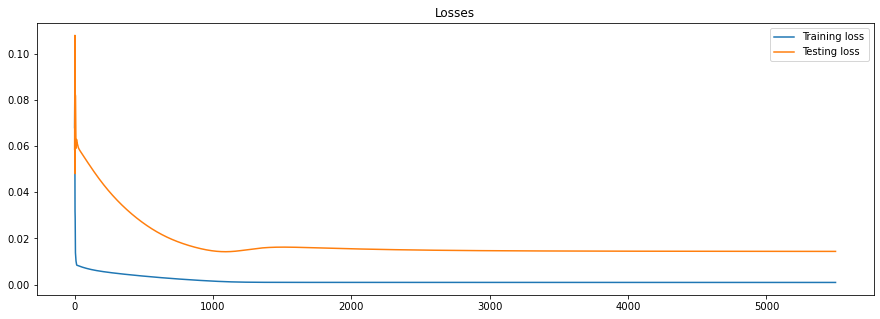

In [99]:
import torch.optim as optim

# hyper-parameters
input_dim = len(x_train.columns)
output_dim = 1        #不可改
hidden_dim = 128      #這邊可以改 2次方
layer_dim = 5        #這邊可以改
batch_size = 128      #這邊可以改
dropout = 0         #遺忘層 這邊可以改 
n_epochs = 5500     #這邊可以改
learning_rate = 1e-3   # gradient descend 收斂過程，learning rate跑的距離
weight_decay = 1e-6



model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = select_model('rnn', model_params)        #model selection, change variables

loss_fn = nn.MSELoss(reduction="mean")                # can change into L1Loss 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# newly added
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80],gamma=0.1)



opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer, scheduler = scheduler)
opt.train(train_loader,test_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

# Step 4: Evaluation 

**we need first to reduce these multi-dimensional tensors to a one-dimensional vector, i.e., flatten, and then apply inverse_transform() to get the predictions' real values.**

In [100]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"WTI_value": vals, "WTI_prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["WTI_value", "WTI_prediction"]])
    return df_result


df_result = format_predictions(predictions, values, x_test, scaler)

In [101]:
df_result

,WTI_value,WTI_prediction
Dates,,
2018-08-10,67.629997,58.767426
2018-08-17,65.910004,58.286476
2018-08-24,68.719994,61.831970
2018-08-31,69.799995,63.179138
2018-09-07,67.749992,61.609699
...,...,...
2021-11-05,81.269997,82.109009
2021-11-12,80.790001,81.386299
2021-11-19,76.099991,78.472969


## 預測與真實WTI比較圖表

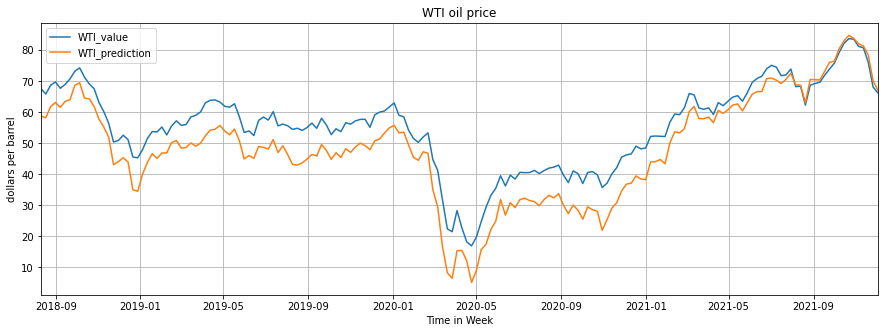

In [102]:
#plotting the comparison b/w real value and prediction 

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('WTI oil price')
plt.ylabel('dollars per barrel')
plt.xlabel('Time in Week')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df_result['WTI_value']) 
plt.plot(df_result['WTI_prediction'])
plt.legend(['WTI_value','WTI_prediction'])

**After flattening and de-scaling the values, we can now calculate error metrics, such as \
mean absolute error (MAE), \
mean squared error (MSE), \
and root mean squared error (RMSE).**

In [103]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.WTI_value, df.WTI_prediction),
            'rmse' : mean_squared_error(df.WTI_value, df.WTI_prediction) ** 0.5,
            'r2' : r2_score(df.WTI_value, df.WTI_prediction)}

result_metrics = calculate_metrics(df_result)
result_metrics

{'mae': 7.1565228, 'rmse': 7.905758808543756, 'r2': 0.6637673484685349}

## record result (rnn)
- hidden layer = 128 ; layer_dim = 6 ; batch = 128 ; epoch = 4000 --> rmse = 7.05 ; r2 = 0.73 (rnn)

---
- hidden layer = 128 ; layer_dim = 5 ; batch = 128 ; epoch = 4500 --> rmse = 4.19 ; r2 = 0.91 (rnn)
- hidden layer = 128 ; layer_dim = 5 ; batch = 128 ; epoch = 5000 --> rmse = 2.78 ; r2 = 0.96 (rnn)
- hidden layer = 128 ; layer_dim = 5 ; batch = 128 ; epoch = 5500 --> rmse = 2.52 ; r2 = 0.97 (rnn) the best 
- hidden layer = 128 ; layer_dim = 5 ; batch = 128 ; epoch = 6000 --> rmse = 3.74 ; r2 = 0.92 (rnn)
- hidden layer = 128 ; layer_dim = 5 ; batch = 128 ; epoch = 6500 --> rmse = 3.34 ; r2 = 0.94 (rnn)
- hidden layer = 128 ; layer_dim = 5 ; batch = 128 ; epoch = 7000 --> rmse = 4.15 ; r2 = 0.91 (rnn) 

---
- hidden layer = 128 ; layer_dim = 4 ; batch = 128 ; epoch = 4000 --> rmse = 5.11 ; r2 = 0.86 (rnn)
- hidden layer = 128 ; layer_dim = 4 ; batch = 128 ; epoch = 4500 --> rmse = 5.30 ; r2 = 0.85 (rnn)
- hidden layer = 128 ; layer_dim = 4 ; batch = 128 ; epoch = 5000 --> rmse = 5.33 ; r2 = 0.85 (rnn)
- hidden layer = 128 ; layer_dim = 4 ; batch = 128 ; epoch = 5500 --> rmse = 4.33 ; r2 = 0.90 (rnn)
- hidden layer = 128 ; layer_dim = 4 ; batch = 128 ; epoch = 6000 --> rmse = 4.10 ; r2 = 0.91 (rnn)
- hidden layer = 128 ; layer_dim = 4 ; batch = 128 ; epoch = 6500 --> rmse = 3.06 ; r2 = 0.95 (rnn) the best 
- hidden layer = 128 ; layer_dim = 4 ; batch = 128 ; epoch = 7000 --> rmse = 3.94 ; r2 = 0.92 (rnn)

## record result (bilstm) 

- hidden layer = 64 ; layer_dim = 5 ; batch = 128 ; epoch = 4000 --> rmse = 7.83 ; r2 = 0.67 (bilstm)
- hidden layer = 64 ; layer_dim = 4 ; batch = 128 ; epoch = 4000 --> rmse = 7.93 ; r2 = 0.66 (bilstm)
- hidden layer = 64 ; layer_dim = 3 ; batch = 128 ; epoch = 4000 --> rmse = 7.04 ; r2 = 0.73 (bilstm)
- hidden layer = 64 ; layer_dim = 2 ; batch = 128 ; epoch = 4000 --> rmse = 8.67 ; r2 = 0.60 (bilstm)
---
- hidden layer = 32 ; layer_dim = 3 ; batch = 128 ; epoch = 4000 --> rmse = 9.36 ; r2 = 0.53 (bilstm)
- hidden layer = 32 ; layer_dim = 4 ; batch = 128 ; epoch = 4000 --> rmse = 8.77 ; r2 = 0.59 (bilstm)

## record result (birnn) 

- hidden layer = 128 ; layer_dim = 5 ; batch = 128 ; epoch = 4000 --> rmse = 9.75 ; r2 = 0.49 (birnn)
- hidden layer = 64 ; layer_dim = 5 ; batch = 128 ; epoch = 4000 --> rmse = 4.45 ; r2 = 0.89 (birnn) 
---
- hidden layer = 64 ; layer_dim = 5 ; batch = 128 ; epoch = 4000 --> rmse = 4.45 ; r2 = 0.89 (birnn) 
- hidden layer = 64 ; layer_dim = 5 ; batch = 128 ; epoch = 5000 --> rmse = 3.76 ; r2 = 0.92 (birnn) the best
- hidden layer = 64 ; layer_dim = 4 ; batch = 128 ; epoch = 5000 --> rmse = 4.61 ; r2 = 0.89 (birnn) 
- hidden layer = 64 ; layer_dim = 5 ; batch = 128 ; epoch = 6000 --> rmse = 4.70 ; r2 = 0.88 (birnn)
- hidden layer = 64 ; layer_dim = 4 ; batch = 128 ; epoch = 6000 --> rmse = 4.53 ; r2 = 0.89 (birnn)
---
- hidden layer = 64 ; layer_dim = 3 ; batch = 128 ; epoch = 5000 --> rmse = 4.53 ; r2 = 0.89 (birnn)
- hidden layer = 64 ; layer_dim = 2 ; batch = 128 ; epoch = 5000 --> rmse = 7.14 ; r2 = 0.72 (birnn)
- hidden layer = 64 ; layer_dim = 1 ; batch = 128 ; epoch = 5000 --> rmse = 8.81 ; r2 = 0.58 (birnn)

## record result (gru) 

- hidden layer = 128 ; layer_dim = 5 ; batch = 128 ; epoch = 4500 --> rmse = 9.69 ; r2 = 0.50 (gru)
---
- hidden layer = 128 ; layer_dim = 4 ; batch = 128 ; epoch = 4000 --> rmse = 9.19 ; r2 = 0.55 (gru)
- hidden layer = 128 ; layer_dim = 4 ; batch = 128 ; epoch = 4500 --> rmse = 9.35 ; r2 = 0.53 (gru)
---
- hidden layer = 64 ; layer_dim = 4 ; batch = 128 ; epoch = 4000 --> rmse = 8.42 ; r2 = 0.62 (gru)
- hidden layer = 64 ; layer_dim = 4 ; batch = 128 ; epoch = 4500 --> rmse = 7.02 ; r2 = 0.73 (gru)
- hidden layer = 64 ; layer_dim = 4 ; batch = 128 ; epoch = 5000 --> rmse = 9.50 ; r2 = 0.51 (gru)
- hidden layer = 64 ; layer_dim = 3 ; batch = 128 ; epoch = 5000 --> rmse = 6.33 ; r2 = 0.78 (gru) the best 
- hidden layer = 64 ; layer_dim = 3 ; batch = 128 ; epoch = 6000 --> rmse = 7.53 ; r2 = 0.69 (gru)
---
- hidden layer = 32 ; layer_dim = 4 ; batch = 128 ; epoch = 5000 --> rmse = 9.34 ; r2 = 0.53 (gru)

## record result (lstm)

- hidden layer = 64 ; layer_dim = 5 ; batch = 128 ; epoch = 4000 --> rmse = 7.74 ; r2 = 0.68 (lstm)
- hidden layer = 64 ; layer_dim = 5 ; batch = 128 ; epoch = 4500 --> rmse = 7.32 ; r2 = 0.71 (lstm) the best 

---
- hidden layer = 128 ; layer_dim = 5 ; batch = 128 ; epoch = 2000 --> rmse = 8.57 ; r2 = 0.60 (lstm)
- hidden layer = 128 ; layer_dim = 5 ; batch = 128 ; epoch = 4000 --> rmse = 8.59 ; r2 = 0.60 (lstm)
- hidden layer = 128 ; layer_dim = 5 ; batch = 128 ; epoch = 4500 --> rmse = 10.04 ; r2 = 0.46 (lstm)